In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

gdp = pd.read_csv('data/gdp.csv')
inflation = pd.read_csv('data/inflation.csv')
unemployment = pd.read_csv('data/unemployment.csv')
yield_data = pd.read_csv('data/yield.csv') 


### Yield curves

            LongTermRate     Slope
Date                              
1961-06-30      0.160110  0.463769
1961-07-31      0.164034  0.446137
1961-08-31      0.169935  0.452569
1961-09-30      0.165211  0.453090
1961-10-31      0.152620  0.455216


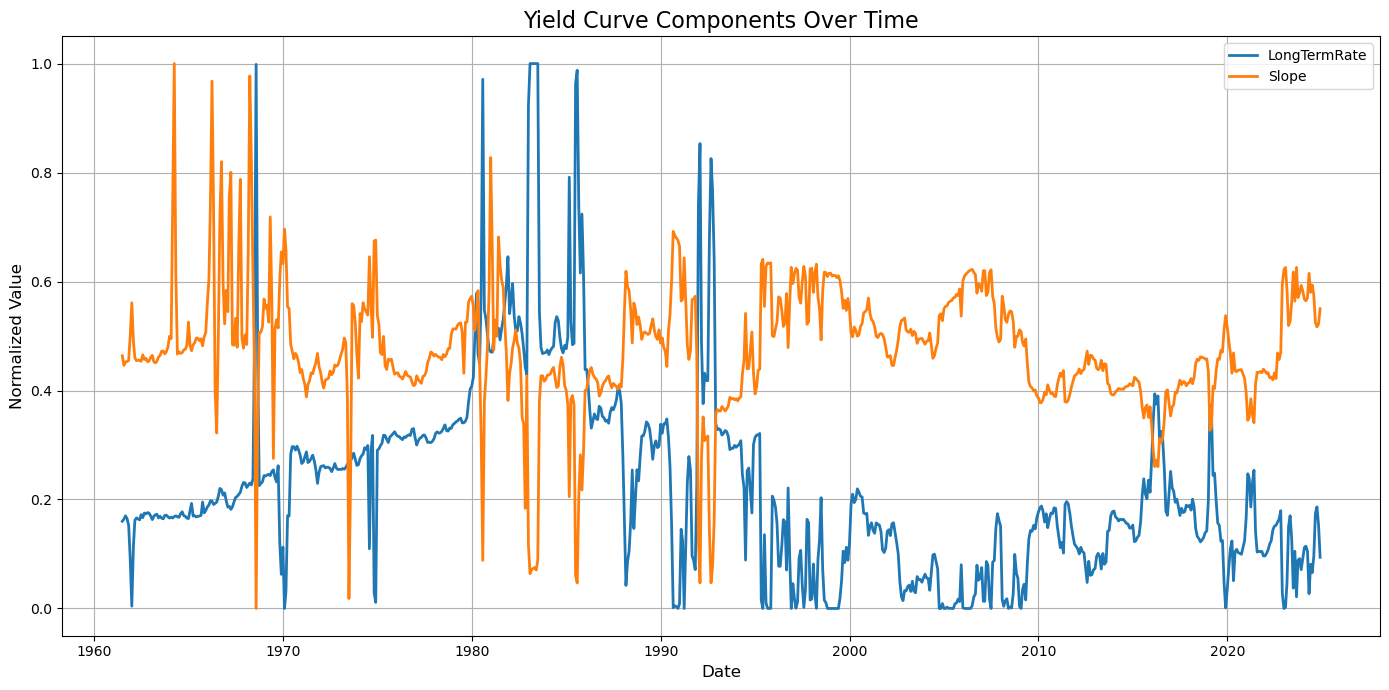

In [244]:
# Convert to datetime
yield_data['Date'] = pd.to_datetime(yield_data['Date'], errors='coerce')

# Replace invalid values with NaN
yield_data.replace(-999.99, pd.NA, inplace=True)

# Drop columns with more than 20% missing values
threshold = 0.2 * len(yield_data)
columns_to_drop = yield_data.columns[yield_data.isnull().sum() > threshold]
yield_data = yield_data.drop(columns=columns_to_drop)

# Rename columns
column_rename_mapping = {
    'BETA0': 'LongTermRate',    # Reflects investor confidence about long-term economic growth and inflation
    'BETA1': 'Slope',           # A negative slope (yield curve inversion) signals a possible recession
}

for i in range(1, 31):
    column_rename_mapping[f'SVENPY{i:02d}'] = f'SpotRate{i}Y'
    column_rename_mapping[f'SVEN1F{i:02d}'] = f'ForwardRate{i}Y'

yield_data.rename(columns=column_rename_mapping, inplace=True)

# Set 'Date' as the index for resampling
yield_data.set_index('Date', inplace=True)

# Resample to monthly frequency
monthly_data = yield_data.resample('M').mean()

# Interpolate missing values for continuous features, including key features
monthly_data_interpolated = monthly_data.interpolate(method='linear', limit_direction='forward', axis=0)

# Normalize continuous features (focus on LongTermRate and Slope)
features_to_normalize = ['LongTermRate', 'Slope']
monthly_data_interpolated[features_to_normalize] = monthly_data_interpolated[features_to_normalize].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
)

# Display the first few rows of the processed dataset
print(monthly_data_interpolated[features_to_normalize].head())

# Plot: Line plot for LongTermRate and Slope
plt.figure(figsize=(14, 7))
plt.plot(monthly_data_interpolated.index, monthly_data_interpolated['LongTermRate'], label='LongTermRate', linewidth=2)
plt.plot(monthly_data_interpolated.index, monthly_data_interpolated['Slope'], label='Slope', linewidth=2)

# Add labels, legend, and title
plt.title('Yield Curve Components Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Unemployment

            overall_rate  men_rate  women_rate  men_16_17_rate  \
date                                                             
1948-01-01      0.073171       3.4         3.3             9.7   
1948-02-01      0.105691       3.6         4.5            13.0   
1948-03-01      0.121951       3.8         4.4            14.0   
1948-04-01      0.113821       3.8         4.3            11.6   
1948-05-01      0.081301       3.5         3.7             7.1   

            women_16_17_rate  men_16_19_rate  women_16_19_rate  \
date                                                             
1948-01-01               8.8             9.4               7.2   
1948-02-01              13.2            10.8               8.9   
1948-03-01              11.4            11.9               8.6   
1948-04-01              10.6             9.8               9.2   
1948-05-01               5.4             7.6               6.1   

            men_18_19_rate  women_18_19_rate  men_16_24_rate  ...  \
date 

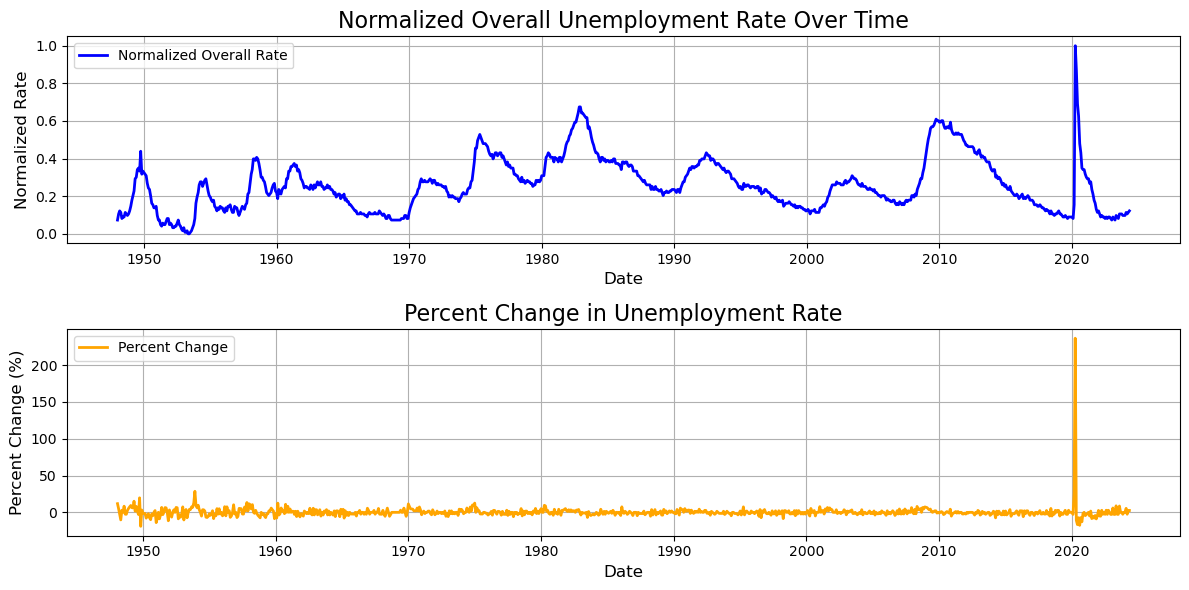

In [245]:
from sklearn.preprocessing import MinMaxScaler

# Convert to datetime and set index
unemployment['date'] = pd.to_datetime(unemployment['date'], errors='coerce')
unemployment.set_index('date', inplace=True)
unemployment.sort_index(inplace=True)

# Find and fill all missing data while dropping columns that don't meet the threshold
threshold = 0.2 * len(unemployment)
columns_to_drop = unemployment.columns[unemployment.isnull().sum() > threshold]
unemployment = unemployment.drop(columns=columns_to_drop)
unemployment.interpolate(method='linear', inplace=True)  # Use linear interpolation for filling NA values

# Calculate percent change for 'overall_rate'
unemployment['unemployment_percent_change'] = unemployment['overall_rate'].pct_change() * 100

# Normalize 'overall_rate' using MinMaxScaler
scaler = MinMaxScaler()
unemployment['overall_rate'] = scaler.fit_transform(unemployment[['overall_rate']])

# Display the first few rows
print(unemployment.head())

# Plot normalized overall rate
plt.figure(figsize=(12, 6))

# Original Unemployment Rate
plt.subplot(2, 1, 1)
plt.plot(unemployment.index, unemployment['overall_rate'], label='Normalized Overall Rate', color='blue', linewidth=2)
plt.title('Normalized Overall Unemployment Rate Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Rate', fontsize=12)
plt.legend()
plt.grid(True)

# Percent Change
plt.subplot(2, 1, 2)
plt.plot(unemployment.index, unemployment['unemployment_percent_change'], label='Percent Change', color='orange', linewidth=2)
plt.title('Percent Change in Unemployment Rate', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percent Change (%)', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Inflation

            value  value_normalized  inflation_percent_change
date                                                         
1947-02-28  21.62          0.000496                  0.651769
1947-03-31  22.00          0.001842                  1.757632
1947-04-30  22.00          0.001842                  0.000000
1947-05-31  21.95          0.001665                 -0.227273
1947-06-30  22.08          0.002125                  0.592255


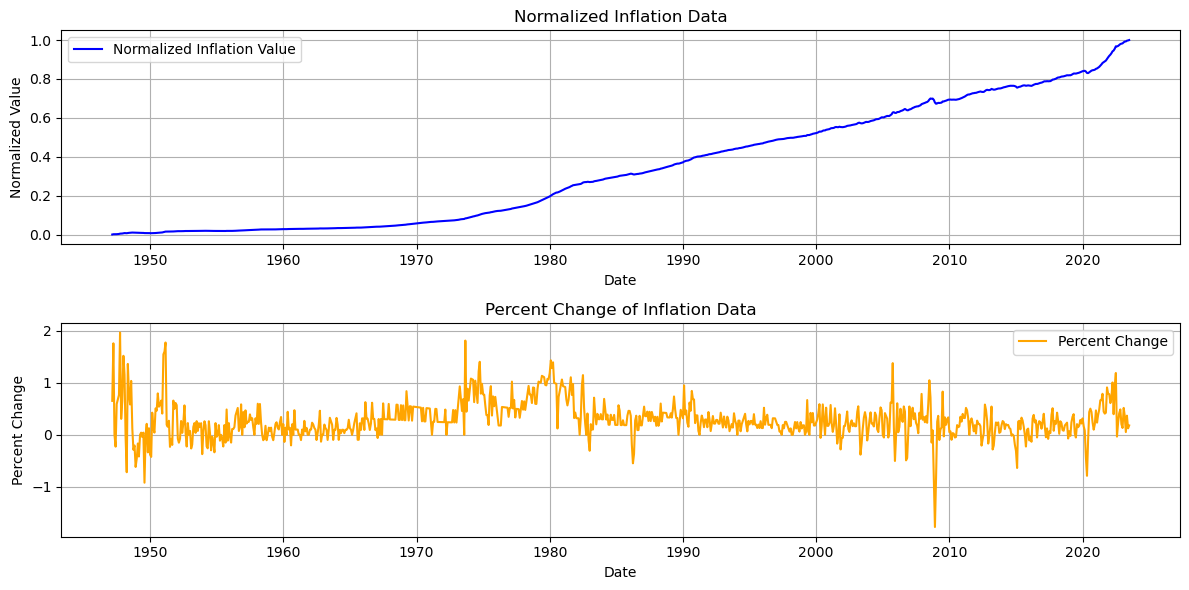

In [246]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'date' column is set as index
inflation['date'] = pd.to_datetime(inflation['date'], errors='coerce')
inflation.set_index('date', inplace=True)
inflation.sort_index(inplace=True)

# Resample to ensure monthly frequency
inflation = inflation.resample('M').mean()

# Fill missing values using linear interpolation
inflation.interpolate(method='linear', inplace=True)

# Normalize the 'value' column
inflation['value_normalized'] = (inflation['value'] - inflation['value'].min()) / (inflation['value'].max() - inflation['value'].min())

# Calculate the percent change
inflation['inflation_percent_change'] = inflation['value'].pct_change() * 100

# Drop NaN values resulting from percent change calculation
inflation = inflation.dropna(subset=['inflation_percent_change'])

print(inflation.head())

# Plot the normalized original data and percent change
plt.figure(figsize=(12, 6))

# Normalized Inflation Data
plt.subplot(2, 1, 1)
plt.plot(inflation.index, inflation['value_normalized'], label='Normalized Inflation Value', color='blue')
plt.title('Normalized Inflation Data')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)

# Percent Change Data
plt.subplot(2, 1, 2)
plt.plot(inflation.index, inflation['inflation_percent_change'], label='Percent Change', color='orange')
plt.title('Percent Change of Inflation Data')
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### GDP

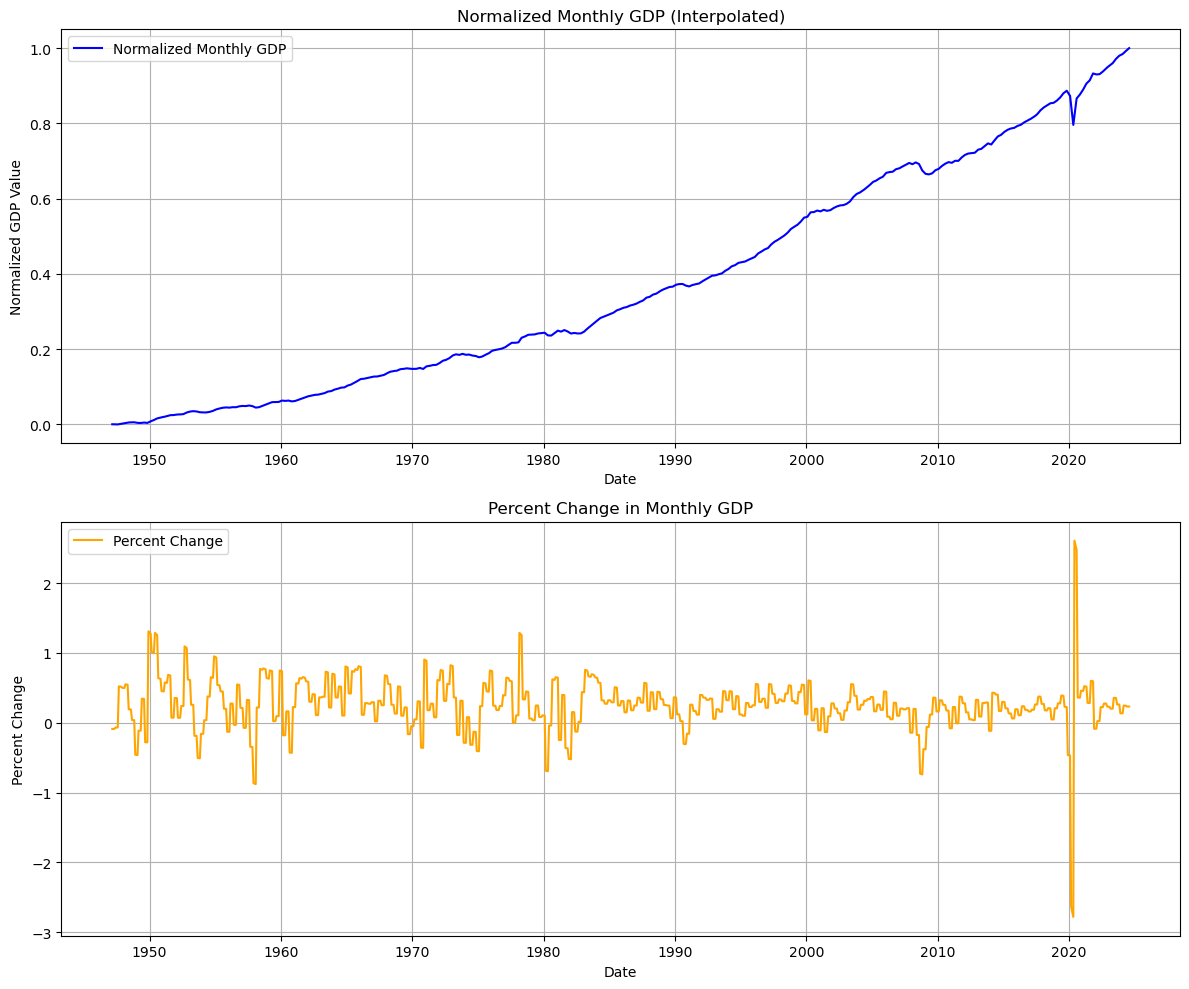

In [247]:
# Convert DATE to datetime and set as index
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp.set_index('DATE', inplace=True)
gdp.sort_index(inplace=True)

# Resample to monthly frequency
gdp = gdp.resample('M').mean()
gdp = gdp.interpolate(method='linear')

# Calculate percent change
gdp['gdp_percent_change'] = gdp['GDPC1'].pct_change() * 100

# Normalize GDP values
gdp['GDPC1_normalized'] = (gdp['GDPC1'] - gdp['GDPC1'].min()) / (gdp['GDPC1'].max() - gdp['GDPC1'].min())

# Drop NaN values from percent change
gdp = gdp.dropna(subset=['gdp_percent_change'])

# Visualization
plt.figure(figsize=(12, 10))

# Monthly GDP (Normalized)
plt.subplot(2, 1, 1)
plt.plot(gdp.index, gdp['GDPC1_normalized'], label='Normalized Monthly GDP', color='blue')
plt.title('Normalized Monthly GDP (Interpolated)')
plt.xlabel('Date')
plt.ylabel('Normalized GDP Value')
plt.legend()
plt.grid(True)

# Percent Change in GDP
plt.subplot(2, 1, 2)
plt.plot(gdp.index, gdp['gdp_percent_change'], label='Percent Change', color='orange')
plt.title('Percent Change in Monthly GDP')
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Data Date Range

In [248]:
import pandas as pd

# GDP Dataset
print("GDP Dataset:")
gdp.index = pd.to_datetime(gdp.index, errors='coerce')  # Ensure index is datetime
print("GDP Index Type:", gdp.index.dtype)
print("GDP Date Range:", gdp.index.min(), "to", gdp.index.max())

# Inflation Dataset
print("\nInflation Dataset:")
inflation['date'] = pd.to_datetime(inflation.index, errors='coerce')  # Convert 'date' column to datetime
inflation.set_index('date', inplace=True)  # Set 'date' as index
print("Inflation Index Type:", inflation.index.dtype)
print("Inflation Date Range:", inflation.index.min(), "to", inflation.index.max())

# Unemployment Dataset
print("\nUnemployment Dataset:")
unemployment['date'] = pd.to_datetime(unemployment.index, errors='coerce')  # Convert 'date' column to datetime
unemployment.set_index('date', inplace=True)  # Set 'date' as index
print("Unemployment Index Type:", unemployment.index.dtype)
print("Unemployment Date Range:", unemployment.index.min(), "to", unemployment.index.max())

# Yield Curve Dataset
print("\nYield Curve Dataset:")
yield_data['Date'] = pd.to_datetime(yield_data.index, errors='coerce')  # Convert 'Date' column to datetime
yield_data.set_index('Date', inplace=True)  # Set 'Date' as index
print("Yield Curve Index Type:", yield_data.index.dtype)
print("Yield Curve Date Range:", yield_data.index.min(), "to", yield_data.index.max())


GDP Dataset:
GDP Index Type: datetime64[ns]
GDP Date Range: 1947-02-28 00:00:00 to 2024-07-31 00:00:00

Inflation Dataset:
Inflation Index Type: datetime64[ns]
Inflation Date Range: 1947-02-28 00:00:00 to 2023-06-30 00:00:00

Unemployment Dataset:
Unemployment Index Type: datetime64[ns]
Unemployment Date Range: 1948-01-01 00:00:00 to 2024-05-01 00:00:00

Yield Curve Dataset:
Yield Curve Index Type: datetime64[ns]
Yield Curve Date Range: 1961-06-14 00:00:00 to 2024-11-15 00:00:00


### Align and Merge Datasets

In [249]:
common_start_date = max(
    gdp.index.min(),
    inflation.index.min(),
    unemployment.index.min(),
    yield_data.index.min()
)
common_end_date = min(
    gdp.index.max(),
    inflation.index.max(),
    unemployment.index.max(),
    yield_data.index.max()
)

gdp_aligned = gdp.resample('M').mean().loc[common_start_date:common_end_date]
inflation_aligned = inflation.resample('M').mean().loc[common_start_date:common_end_date]
unemployment_aligned = unemployment.resample('M').mean().loc[common_start_date:common_end_date]
yield_curve_aligned = yield_data.resample('M').mean().loc[common_start_date:common_end_date]

# Merge all datasets on the date index with monthly frequency
merged_data = gdp_aligned \
    .merge(inflation_aligned, left_index=True, right_index=True, how='inner', suffixes=('', '_inflation')) \
    .merge(unemployment_aligned, left_index=True, right_index=True, how='inner', suffixes=('', '_unemployment')) \
    .merge(yield_curve_aligned, left_index=True, right_index=True, how='inner', suffixes=('', '_yield_curve'))

# Display the result
print("Merged Data Summary:")
print(merged_data.info())
print(merged_data.head())


Merged Data Summary:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 745 entries, 1961-06-30 to 2023-06-30
Freq: M
Data columns (total 69 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   GDPC1                        745 non-null    float64
 1   gdp_percent_change           745 non-null    float64
 2   GDPC1_normalized             745 non-null    float64
 3   value                        745 non-null    float64
 4   value_normalized             745 non-null    float64
 5   inflation_percent_change     745 non-null    float64
 6   overall_rate                 745 non-null    float64
 7   men_rate                     745 non-null    float64
 8   women_rate                   745 non-null    float64
 9   men_16_17_rate               745 non-null    float64
 10  women_16_17_rate             745 non-null    float64
 11  men_16_19_rate               745 non-null    float64
 12  women_16_19_rate             7

### New Dataset